In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import os
import pickle
from tensorflow.keras.initializers import HeNormal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

from google.colab import drive
drive.mount('/content/drive')

! pip install tensorflow-addons
import tensorflow_addons as tfa

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def build_encoder_decoder(input_shape, conv_filters, conv_kernels, conv_strides, latent_dim, pre_latent_dense_size_factor=None, decoder_activation="sigmoid",dropout_rate=0.1,mode = "VAE"):
    encoder_inputs = keras.Input(shape=input_shape, name="encoder_input")
    num_layers = len(conv_filters)
    print("buildmode")
    print(mode)
    # Encoder
    residual_connections = []
    for layer in range(num_layers):
        if layer == 0:
            x = layers.Conv2D(conv_filters[layer], conv_kernels[layer], strides=conv_strides[layer], padding="same", name=f"encoder_conv_layer_{layer+1}")(encoder_inputs)
        else:
            x = layers.Conv2D(conv_filters[layer], conv_kernels[layer], strides=conv_strides[layer], padding="same", name=f"encoder_conv_layer_{layer+1}")(x)
        
        x = layers.LeakyReLU(name=f"encoder_LeakyReLU_{layer+1}")(x)
        x = layers.Dropout(dropout_rate, name=f"encoder_dropout_{layer+1}")(x)
        x = layers.BatchNormalization(name=f"encoder_BN_{layer+1}")(x)

        if layer % 2 == 0:
            residual_connections.append(x)

        if layer % 2 == 1:
            x_residual = layers.Conv2D(conv_filters[layer], 1, strides=conv_strides[layer], padding="same", name=f"encoder_residual_conv_{layer}")(residual_connections.pop())
            x = layers.Add(name=f"encoder_residual_add_{layer}")([x, x_residual])

    shape_before_bottleneck = K.int_shape(x)[1:]
    num_neurons = np.prod(shape_before_bottleneck)
    x = layers.Flatten(name="encoder_flatten")(x)
    x = layers.LeakyReLU(name="encoder_flattened_LeakyReLU")(x)
    x = layers.Dropout(dropout_rate, name=f"encoder_dropout_flatten")(x)

    if pre_latent_dense_size_factor:
        x = layers.Dense(latent_dim * pre_latent_dense_size_factor, name="encoder_pre_latent_dense")(x)
        x = layers.LeakyReLU(name="encoder_dense_LeakyReLU")(x)
        x = layers.Dropout(dropout_rate, name=f"encoder_dropout_pre_latent_dense")(x)

    if mode == "VAE":
      z_mean = layers.Dense(latent_dim, name="z_mean")(x)
      z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
      z = Sampling(name="latent_sample")([z_mean, z_log_var])

      encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    else:
      z = layers.Dense(latent_dim, name="z")(x)
      encoder = keras.Model(encoder_inputs, z, name="encoder")

    encoder.summary()

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,), name="decoder_input")
    if pre_latent_dense_size_factor:
        x = layers.Dense(latent_dim * pre_latent_dense_size_factor, name="decoder_post_latent_dense")(latent_inputs)
        x = layers.LeakyReLU(name="decoder_dense_LeakyReLU")(x)
        x = layers.Dropout(dropout_rate, name=f"edecoder_dropout_post_latent_dense")(x)
        x = layers.Dense(num_neurons, name="decoder_upsize")(x)
    else:
        x = layers.Dense(num_neurons, name="decoder_upsize")(latent_inputs)

    x = layers.LeakyReLU(name="decoder_pre_unflatten_LeakyReLU")(x)
    x = layers.Dropout(dropout_rate, name=f"decoder_dropout_unflatten")(x)
    x = layers.Reshape(shape_before_bottleneck, name="decoder_unflatten")(x)

    residual_connections = []
    for layer in range(num_layers - 1):
        inverted_layer = num_layers - layer - 1
        x = layers.Conv2DTranspose(conv_filters[inverted_layer], conv_kernels[inverted_layer], strides=conv_strides[inverted_layer], padding="same", name=f"decoder_conv_layer_{layer+1}")(x)
        x = layers.LeakyReLU(name=f"decoder_LeakyReLU_{layer+1}")(x)
        
        x = layers.Dropout(dropout_rate, name=f"decoder_dropout_{layer+1}")(x)

        x = layers.BatchNormalization(name=f"decoder_BN_{layer+1}")(x)
        if layer % 2 == 0:
            residual_connections.append(x)

        if layer % 2 == 1:
            x_residual = layers.Conv2DTranspose(conv_filters[inverted_layer], 1, strides=conv_strides[inverted_layer], padding="same", name=f"decoder_residual_conv_{layer}")(residual_connections.pop())
            x = layers.Add(name=f"decoder_residual_add_{layer}")([x, x_residual])

    decoder_outputs = layers.Conv2DTranspose(input_shape[-1], conv_kernels[0], activation=decoder_activation, strides=conv_strides[0], padding="same", name=f"decoder_output")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    return encoder, decoder

In [ ]:
from tensorflow.keras.callbacks import Callback

class CombinedMetricEarlyStopping(Callback):
    def __init__(self, monitor="val_ssim", mode="max", patience=30, min_delta=0.01, restore_best_weights=True):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None

    def on_train_begin(self, logs=None):
        self.best = float("-inf") if self.mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor) 
        if current is None:
            print(f"Early stopping conditioned on metric `{self.monitor}` which is not available. Available metrics are: {','.join(list(logs.keys()))}")
            return

        if self.mode == "max":
          if current < self.best - self.min_delta*self.best: #give some slack
            is_better = False
          else:
            is_better = current > self.best
            
        else:
          if current > self.best + self.min_delta*self.best:
            is_better = False
          else:
            is_better = current < self.best

        if is_better:
            print("saving best weights")
            print(f"previous best={self.best}")
            print(f"new best={current}")
            print(self.mode)
            self.best = current
            self.wait = 0
            
            

            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")

def pitch_weight(pitch, min_weight=1, max_weight=10):
    min_hz, max_hz = 0, 4000
    
    # Convert pitch to frequency (Hz)
    hz = 2**((pitch - 69) / 12) * 440
    
    # Scale weight based on frequency
    weight_range = max_weight - min_weight
    normalized_hz = 1 - (hz - min_hz) / (max_hz - min_hz)  # Flip the weights
    weight = min_weight + (normalized_hz * weight_range)
    return weight

class VAE(keras.Model):
    def __init__(self, encoder, decoder, loss_type="binary_crossentropy", mode = "VAE", **kwargs):
        super().__init__(**kwargs)
        self.mode = mode
        print(self.mode)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_type = loss_type
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.ssim_tracker = keras.metrics.Mean(name="ssim")
        self.combined_metric_tracker = keras.metrics.Mean(name="combined_kl_ssim")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.ssim_tracker,
        ]
    def call(self, inputs):
        if self.mode == "VAE":
          z_mean, z_log_var, z = self.encoder(inputs)
          reconstruction = self.decoder(z)
          kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
          )
          kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        else:
          z = self.encoder(inputs)
          reconstruction = self.decoder(z)
          kl_loss = 0
        return reconstruction, kl_loss

    def train_step(self, data_and_labels):
      
      #reset just the combined and ssim tracker - better intuition to clear the huge values from first epoch..
      self.combined_metric_tracker.reset_states()
      #self.ssim_tracker.reset_states()

      data, pitch_labels = data_and_labels
      #print(data.shape)
      #print(pitch_labels.shape)
      with tf.GradientTape() as tape:
        reconstruction, kl_loss = self(data)

        if self.loss_type == "binary_crossentropy":
            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
        elif self.loss_type == "mean_squared_error":
            reconstruction_loss = keras.losses.mean_squared_error(data, reconstruction)
        else:
            raise ValueError(f"Unsupported loss type: {self.loss_type}")

        # Scale the reconstruction loss by pitch-dependent weight - as the NSynth people did
        pitch_weights = tf.vectorized_map(pitch_weight, pitch_labels)
        pitch_weights = tf.expand_dims(pitch_weights, axis=-1)
        #print(pitch_weights.shape)
        #print(reconstruction_loss.shape)
        weighted_reconstruction_loss = pitch_weights * reconstruction_loss

        # reduce the losses
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                reconstruction_loss,
                axis=(1, 2),
            )
        )
        weighted_reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                weighted_reconstruction_loss,
                axis=(1, 2),
            )
        )
        # combine the losses
        if self.mode == "VAE":
          total_loss = weighted_reconstruction_loss + 100 * kl_loss
        else:
          total_loss = weighted_reconstruction_loss

        ## get ssim metrics
        ssim = tf.reduce_mean(tf.image.ssim(data, reconstruction, max_val=1.0))
        combined_kl_ssim_metric = 0.005 * kl_loss + 1 / ssim

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      self.ssim_tracker.update_state(ssim)
      self.combined_metric_tracker.update_state(combined_kl_ssim_metric)
      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
          "ssim": self.ssim_tracker.result(),
          "combined_kl_ssim_metric": self.combined_metric_tracker.result(),
      }
    
    def test_step(self, data_and_labels):

      #reset just the combined metric and ssim
      self.combined_metric_tracker.reset_states()
      #self.ssim_tracker.reset_states()
      data, pitch_labels = data_and_labels

      # Perform forward pass
      reconstruction, kl_loss = self(data, training=False)

      # Compute loss and metrics
      if self.loss_type == "binary_crossentropy":
          reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
      elif self.loss_type == "mean_squared_error":
          reconstruction_loss = keras.losses.mean_squared_error(data, reconstruction)
      else:
          raise ValueError(f"Unsupported loss type: {self.loss_type}")

      # Scale the reconstruction loss by pitch-dependent weight - as the NSynth people did
      pitch_weights = tf.vectorized_map(pitch_weight, pitch_labels)
      pitch_weights = tf.expand_dims(pitch_weights, axis=-1)
      #print(pitch_weights.shape)
      #print(reconstruction_loss.shape)
      weighted_reconstruction_loss = pitch_weights * reconstruction_loss

      # reduce the losses
      reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              reconstruction_loss,
              axis=(1, 2),
          )
      )
      weighted_reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              weighted_reconstruction_loss,
              axis=(1, 2),
          )
      )
      # combine the losses
      if self.mode == "VAE":
        total_loss = weighted_reconstruction_loss + 100 * kl_loss
      else:
        total_loss = weighted_reconstruction_loss

      # get ssim metrics
      ssim = tf.reduce_mean(tf.image.ssim(data, reconstruction, max_val=1.0))
      combined_kl_ssim_metric = 0.005 * kl_loss + 1 / ssim

      # Update validation metrics
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      self.ssim_tracker.update_state(ssim)
      self.combined_metric_tracker.update_state(combined_kl_ssim_metric)

      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
          "ssim": self.ssim_tracker.result(),
          "combined_kl_ssim_metric": self.combined_metric_tracker.result(),
      }


In [ ]:
def load_VAE(VAE_parameters_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_VAE_parameters.pkl",
             encoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_encoder_weights.h5",
             decoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_decoder_weights.h5",
             history_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_history.pkl"
             ):
  
    with open(VAE_parameters_file, "rb") as f:
        parameters = pickle.load(f)
        
        input_shape = parameters[0]
        conv_filters = parameters[1]
        conv_kernels = parameters[2]
        conv_strides = parameters[3]
        latent_dim = parameters[4]
        pre_latent_dense_size_factor = parameters[5]

        #account for some older parameter files not having last values
        if len(parameters) < 7: #if dont have decoder activation function
          decoder_activation = "sigmoid" #assume sigmoid
        else:
          decoder_activation = parameters[6]

    encoder,decoder = build_encoder_decoder(input_shape,conv_filters,conv_kernels,conv_strides,latent_dim,pre_latent_dense_size_factor,decoder_activation)
    loaded_vae = VAE(encoder,decoder)

    loaded_vae.encoder.load_weights(encoder_weights_file)
    loaded_vae.decoder.load_weights(decoder_weights_file)

    with open(history_file, "rb") as f:
        history = pickle.load(f)

    return loaded_vae, parameters, history, latent_dim


In [ ]:
VAE_parameters_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/VAE2023-04-21_23-38_parameters.pkl"
encoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/encoder2023-04-21_23-38_weights.h5"
decoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/decoder2023-04-21_23-38_weights.h5"
history_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_history.pkl"
vae,parameters,history,latent_dim = load_VAE(
  VAE_parameters_file,
  encoder_weights_file,
  decoder_weights_file,
  history_file
  )

buildmode
VAE
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 1024, 192,   0           []                               
                                1)]                                                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 512, 96, 64)  1664        ['encoder_input[0][0]']          
                                                                                                  
 encoder_LeakyReLU_1 (LeakyReLU  (None, 512, 96, 64)  0          ['encoder_conv_layer_1[0][0]']   
 )                                                                                                
                                                                              

In [ ]:
import numpy as np
import librosa
import soundfile as sf
from tqdm import tqdm

# Define the range and step size for the first latent dimension
latent_1_range = np.arange(-10, 12, 2)

# Define the remaining latent dimensions (assuming they are 7 in total)
latent_dims = 8
samplerate = 16000
hop_length = 256
n_fft = 2048
n_iter = 100

for i, latent_1_val in enumerate(latent_1_range): #keeping all other at 0
    # Generate the latent vector
    latent_vec = np.zeros((1,latent_dims))
    latent_vec[:,7] = latent_1_val


    # Generate the spectrogram
    spectrogram = vae.decoder.predict(latent_vec)[0]
    spectrogram = np.squeeze(spectrogram)
    # Convert the spectrogram to a sound using Griffon Lim
    phase = np.random.rand(*spectrogram.shape)
    for _ in tqdm(range(n_iter),total=n_iter):
        spec = spectrogram * np.exp(1j * phase)
        sound = librosa.istft(spec, n_fft = n_fft, hop_length=hop_length)
        phase = np.angle(librosa.stft(sound, n_fft=2048, hop_length=hop_length, center = True)[:-1])
    
    # Normalize the sound to [-1, 1]
    sound = sound / np.max(np.abs(sound))
    
    # Save the sound as a .wav file
    filename = f"/content/drive/MyDrive/Variational_Auto_Encoder/latentspaceexplo/varylatent8/latent8is{latent_1_val}.wav"
    sf.write(filename, sound, samplerate)


1/1 [==============================] - 0s 498ms/step


100%|██████████| 100/100 [00:04<00:00, 23.40it/s]


1/1 [==============================] - 0s 390ms/step


100%|██████████| 100/100 [00:05<00:00, 18.59it/s]


1/1 [==============================] - 0s 371ms/step


100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


1/1 [==============================] - 0s 241ms/step


100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


1/1 [==============================] - 0s 283ms/step


100%|██████████| 100/100 [00:04<00:00, 21.23it/s]


1/1 [==============================] - 0s 421ms/step


100%|██████████| 100/100 [00:04<00:00, 22.35it/s]


1/1 [==============================] - 0s 238ms/step


100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


1/1 [==============================] - 0s 250ms/step


100%|██████████| 100/100 [00:03<00:00, 26.05it/s]


1/1 [==============================] - 0s 410ms/step


100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


1/1 [==============================] - 0s 258ms/step


100%|██████████| 100/100 [00:03<00:00, 26.25it/s]


1/1 [==============================] - 0s 238ms/step


100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


In [ ]:
help(tqdm)

In [ ]:
latent_vec = np.zeros((1,latent_dims))
latent_vec[:,3] = 10


# Generate the spectrogram
spectrogram = vae.decoder.predict(latent_vec)[0]
spectrogram = np.squeeze(spectrogram)
# Convert the spectrogram to a sound using Griffon Lim
phase = np.random.rand(*spectrogram.shape)
for _ in tqdm(range(n_iter),total=n_iter):
    spec = spectrogram * np.exp(1j * phase)
    sound = librosa.istft(spec, n_fft = n_fft, hop_length=hop_length)
    phase = np.angle(librosa.stft(sound, n_fft=2048, hop_length=hop_length, center = True)[:-1])

1/1 [==============================] - 0s 367ms/step


100%|██████████| 100/100 [00:05<00:00, 18.34it/s]


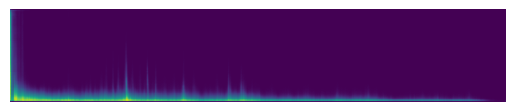

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(np.transpose(spectrogram), origin='lower')